<a href="https://colab.research.google.com/github/sankeawthong/Project-1-Lita-Chatbot/blob/main/%5B20250118%5D%20LSTM%20(Standalone)%20on%20NF-ToN-IoT%20over%2020%20Epochs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**LSTM (Standalone) based on NF-ToN-IoT dataset**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder, StandardScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Bidirectional, Dropout, Flatten
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from keras.utils import to_categorical

In [ ]:
#Load dataset
dataset = pd.read_csv("Dataset_NF-ToN-IoT.csv")
# Preprocessing: Handle missing values (if any)
dataset = dataset.dropna() # Remove missing values

In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 13 columns):
 #   Column                      Non-Null Count    Dtype  
---  ------                      --------------    -----  
 0   L4_SRC_PORT                 1048575 non-null  int64  
 1   L4_DST_PORT                 1048575 non-null  int64  
 2   PROTOCOL                    1048575 non-null  int64  
 3   L7_PROTO                    1048575 non-null  float64
 4   IN_BYTES                    1048575 non-null  int64  
 5   OUT_BYTES                   1048575 non-null  int64  
 6   IN_PKTS                     1048575 non-null  int64  
 7   OUT_PKTS                    1048575 non-null  int64  
 8   TCP_FLAGS                   1048575 non-null  int64  
 9   FLOW_DURATION_MILLISECONDS  1048575 non-null  int64  
 10  Label                       1048575 non-null  int64  
 11  Attack                      1048575 non-null  object 
 12  Class                       1048575 non-null  int64  
dt

In [ ]:
dataset["Class"].unique()

array([0, 3, 4, 2, 8, 6, 5, 9, 1, 7])

In [ ]:
# Encode non-numeric columns (if any)
for column in dataset.columns:
    if dataset[column].dtype == 'object':  # Identify categorical columns
        dataset[column] = LabelEncoder().fit_transform(dataset[column])

# Separate features (X) and target (y)
X = dataset.drop(['Class'], axis=1)  # Assuming 'Class' is the target column
y = dataset['Class']
print("Original Class Distribution:", np.bincount(y))

Original Class Distribution: [164866  17243 149605  10732 453506   1249 135353    142  15966  99913]


In [ ]:
# Standardize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [ ]:
#Installing imblearn
!pip install -U imbalanced-learn
!pip install imbalanced-learn

In [ ]:
# check version number
import imblearn
print(imblearn.__version__)

0.13.0


**Data Balancing utilized SMOTE**

In [ ]:
from imblearn.over_sampling import SMOTE
# Balance dataset using SMOTE
smote = SMOTE(random_state=42)
X, y = smote.fit_resample(X, y)

# Verify the balanced dataset distribution
print("Balanced Class Distribution:", np.bincount(y))

Balanced Class Distribution: [453506 453506 453506 453506 453506 453506 453506 453506 453506 453506]


**Split data into 80% Training and 20% Testing**

In [ ]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101, stratify=y)

**LSTM for 10 classes classifications based on NF-ToN-IoT dataset**

In [ ]:
#import pandas as pd
#import numpy as np
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
#from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from keras.layers import Dense, Dropout

In [ ]:
from keras.regularizers import l2
# Convert the target variables to categorical variables
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# Define the LSTM model
def build_lstm_model(input_shape, num_classes):
    model = Sequential()

    # LSTM Layer
    model.add(LSTM(128, activation='tanh', input_shape=input_shape, return_sequences=True, kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.3))  # Dropout for regularization

    # Another LSTM Layer
    model.add(LSTM(64, activation='tanh', return_sequences=False, kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.3))

    # Fully Connected Layer
    model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.3))

    # Output Layer
    model.add(Dense(num_classes, activation='softmax'))

    return model

# Reshape X_train and X_test to 3D for LSTM
# Assuming each sample has 1 timestep and all features are considered in that timestep
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

# Now, define input_shape:
#input_shape = (X_train.shape[1], X_train.shape[2])  # For LSTM: (timesteps, features)
# Prepare the input shape and number of classes
input_shape = (X_train.shape[1], X_train.shape[2])  # For LSTM: (timesteps, features)
num_classes = y_train.shape[1]  # Number of output classes

# Build the model
model = build_lstm_model(input_shape, num_classes)

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)

# Evaluate the model
score, acc = model.evaluate(X_test, y_test, batch_size=32)
print('Test score:', score)
print('Test accuracy:', acc)

# Make predictions with the model
predictions = model.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)

# Convert categorical target variables back to class labels
y_true = np.argmax(y_test, axis=1)

# Generate confusion matrix
cm = confusion_matrix(y_true, predicted_classes)
print("Confusion Matrix:")
print(cm)

# Generate classification report
cr = classification_report(y_true, predicted_classes)
print("Classification Report:")
print(cr)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
113377/113377 ━━━━━━━━━━━━━━━━━━━━ 631s 6ms/step - accuracy: 0.9046 - loss: 0.5009 - val_accuracy: 0.9999 - val_loss: 0.1531
Epoch 2/20
113377/113377 ━━━━━━━━━━━━━━━━━━━━ 619s 5ms/step - accuracy: 0.9496 - loss: 0.2852 - val_accuracy: 0.9999 - val_loss: 0.1406
Epoch 3/20
113377/113377 ━━━━━━━━━━━━━━━━━━━━ 624s 6ms/step - accuracy: 0.9512 - loss: 0.2733 - val_accuracy: 0.9987 - val_loss: 0.1378
Epoch 4/20
113377/113377 ━━━━━━━━━━━━━━━━━━━━ 631s 6ms/step - accuracy: 0.9534 - loss: 0.2563 - val_accuracy: 0.9996 - val_loss: 0.1321
Epoch 5/20
113377/113377 ━━━━━━━━━━━━━━━━━━━━ 648s 6ms/step - accuracy: 0.9575 - loss: 0.2410 - val_accuracy: 0.9994 - val_loss: 0.1336
Epoch 6/20
113377/113377 ━━━━━━━━━━━━━━━━━━━━ 641s 6ms/step - accuracy: 0.9572 - loss: 0.2395 - val_accuracy: 0.9995 - val_loss: 0.1198
Epoch 7/20
113377/113377 ━━━━━━━━━━━━━━━━━━━━ 624s 6ms/step - accuracy: 0.9576 - loss: 0.2371 - val_accuracy: 0.9995 - val_loss: 0.1256
Epoch 8/20
113377/113377 ━━━━━━━━━━━━━━━━━━━━ 62

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Calculate predictions
y_pred_classes = np.argmax(predictions, axis=1)  # Convert probabilities to class predictions
y_true_classes = np.argmax(y_test, axis=1)       # Convert one-hot encoded labels to class indices

# Calculate metrics
accuracy = accuracy_score(y_true_classes, y_pred_classes)
precision = precision_score(y_true_classes, y_pred_classes, average='weighted')
recall = recall_score(y_true_classes, y_pred_classes, average='weighted')
f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')

# Print the metrics with 10 decimals
print("Model Performance Metrics:")
print("Accuracy: {:.10f}".format(accuracy))
print("Precision: {:.10f}".format(precision))
print("Recall: {:.10f}".format(recall))
print("F1-Score: {:.10f}".format(f1))

Model Performance Metrics:
Accuracy: 0.9996030924
Precision: 0.9996034817
Recall: 0.9996030924
F1-Score: 0.9996030599


Confusion Matrix of MLP


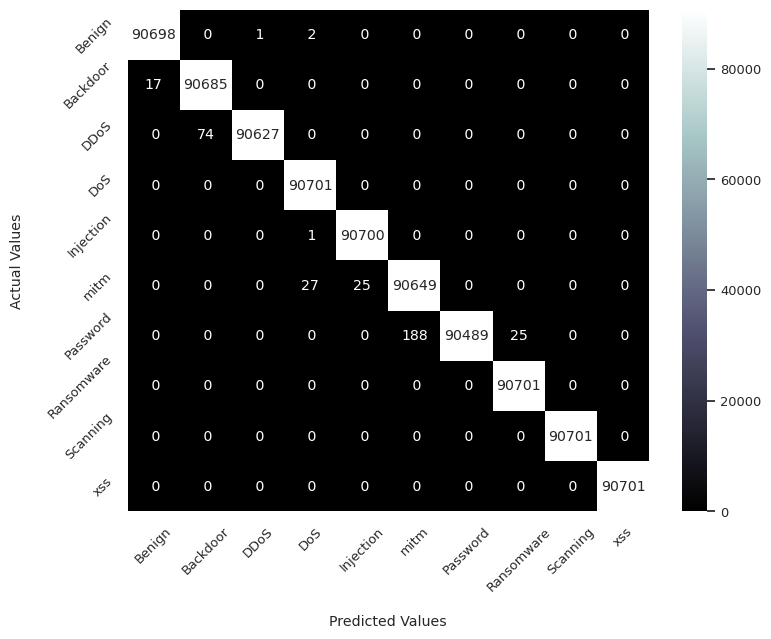

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt # Import matplotlib.pyplot

def conf_mat(d1, d2):
    cm = confusion_matrix(d1, d2)
    plt.figure(figsize=(8, 6.5))
    ax = sns.heatmap(cm, fmt='2', annot=True, cmap='bone')
    sns.set(font_scale=0.85)
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values\n')
    ax.xaxis.set_ticklabels(
        ['Benign','Backdoor','DDoS','DoS','Injection','mitm','Password','Ransomware','Scanning','xss'])
    ax.yaxis.set_ticklabels(
        ['Benign','Backdoor','DDoS','DoS','Injection','mitm','Password','Ransomware','Scanning','xss'])

    plt.xticks(rotation=45)  # Add this line to rotate the x-axis labels by 45 degrees
    plt.yticks(rotation=45)  # Add this line to rotate the x-axis labels by 45 degrees

    plt.tight_layout()
    # plt.savefig("F1.eps", format = 'eps')
    plt.show()

print("Confusion Matrix of MLP")
conf_mat(y_true, predicted_classes) #Calling the function after its definition

In [ ]:
# Compute TP, TN, FP, FN for each class
#cm = confusion_matrix(np.argmax(y_test, axis=1), test_rf_features)
#cm = confusion_matrix(y_test, y_test_prediction)
cm = confusion_matrix(y_true, predicted_classes)

FP = cm.sum(axis=0) - np.diag(cm)
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)

# Compute False Positive Rate (FPR) and True Positive Rate (TPR) for each class
FPR = FP / (FP + TN)
TPR = TP / (TP + FN)

# Print FPR and TPR for each class
for i in range(10):
    print(f"Class {i} - FPR: {FPR[i]}, TPR: {TPR[i]}")

Class 0 - FPR: 2.0825396203162765e-05, TPR: 0.9999669242896991
Class 1 - FPR: 9.065183569967291e-05, TPR: 0.9998125730413883
Class 2 - FPR: 1.2250233060683979e-06, TPR: 0.999184132479245
Class 3 - FPR: 3.675069918205194e-05, TPR: 1.0
Class 4 - FPR: 3.0625582651709946e-05, TPR: 0.999988974763233
Class 5 - FPR: 0.00023030438154085883, TPR: 0.9994266876881182
Class 6 - FPR: 0.0, TPR: 0.9976516504597474
Class 7 - FPR: 3.0625582651709946e-05, TPR: 1.0
Class 8 - FPR: 0.0, TPR: 1.0
Class 9 - FPR: 0.0, TPR: 1.0


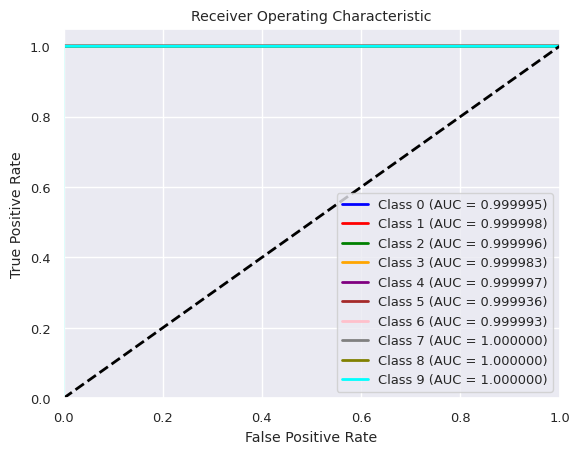

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

# Compute the AUC and ROC curve
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = len(np.unique(y_true))

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curve
plt.figure()
colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label='Class {0} (AUC = {1:1f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

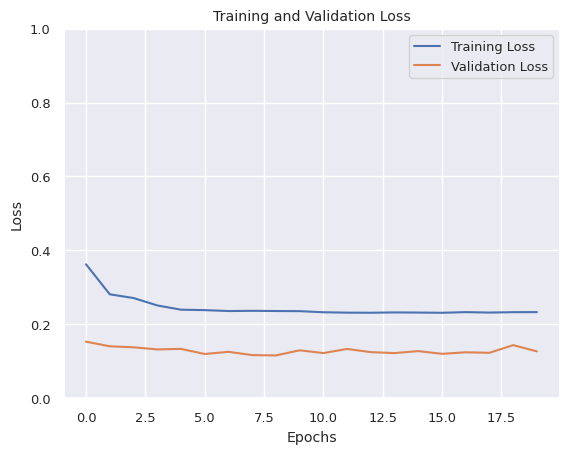

In [ ]:
# Plot Training and Validation Loss
plt.figure()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0, 1)  # Set y-axis scale to 1
plt.legend()
plt.show()